Positioning nodes


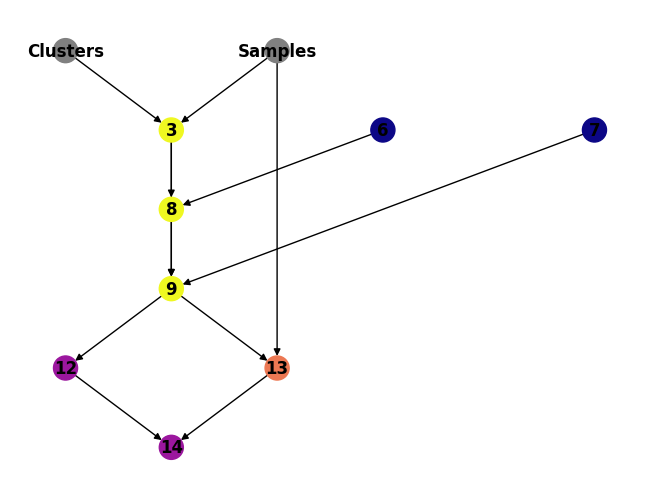

In [2]:
%load_ext autoreload
%autoreload 2
import tensorcraft as tc

from tensorcraft.compiler.compiler import ProgramTransformer
from tensorcraft.viz.program_graph import draw_program_graph, draw_expression_graph
code = """
# Distance computation
Dist[j,k] = (Samples[j,l] - Clusters[k,l]) * (Samples[j,l] - Clusters[k,l])

# Argmin
Min[j] = 1000
Labels[j] = -1
Min[j] = (Dist[j,k] < Min[j]) * (Dist[j,k] - Min[j])
Labels[j] = (Dist[j,k] == Min[j]) * (k - Labels[j])

# Cluster update
Count[l] = (Labels[j] == l)
Update[l,k] = Samples[j,k] * (Labels[j] == l)
Update[l,k] = Update[l,k] / Count[l]
"""
kmeans_kernel = tc.compile(code)

draw_program_graph(kmeans_kernel, color_by="opcount")

Positioning nodes


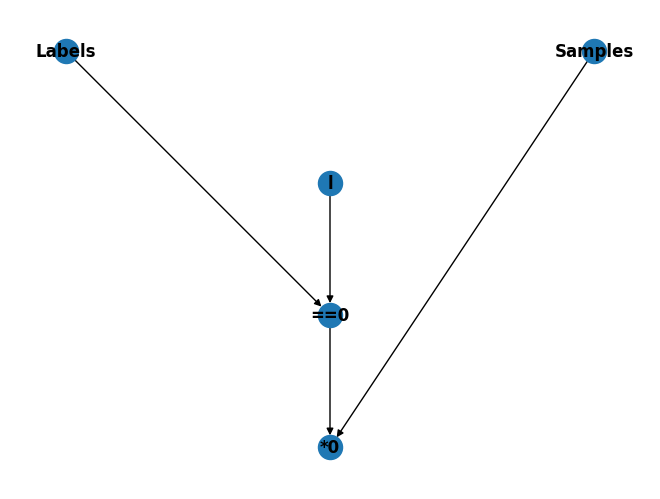

In [7]:
draw_expression_graph(kmeans_kernel.tensor_expressions[13])

Positioning nodes


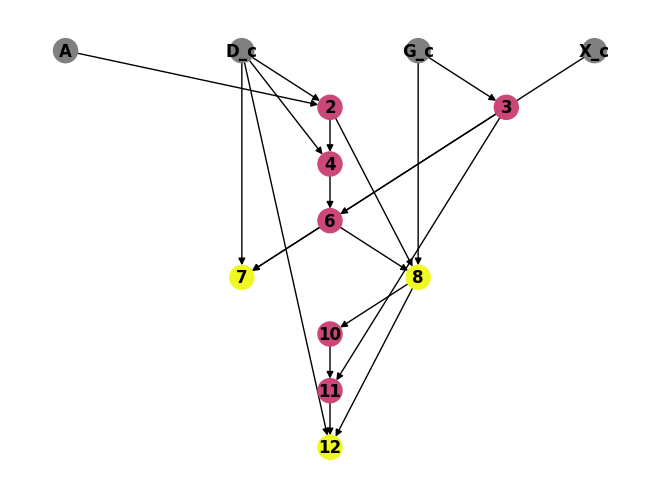

In [9]:
code = """
W_c[i] = A[i,j] * D_c[j]
Gamma_c = G_c[i] * G_c[i]
Theta_c = D_c[i] * W_c[i]

Alpha_c = Gamma_c / Theta_c
X_n[i] = X_c[i] + (Alpha_c * D_c[i])
G_n[i] = G_c[i] + (Alpha_c * W_c[i])

Gamma_n = G_n[i] * G_n[i]
Beta_n = Gamma_n / Gamma_c
Delta_n = (Beta_n * D_c[i]) - G_n[i]
"""
conjugate_gradient_kernel = tc.compile(code)

draw_program_graph(conjugate_gradient_kernel, color_by='opcount')


Positioning nodes


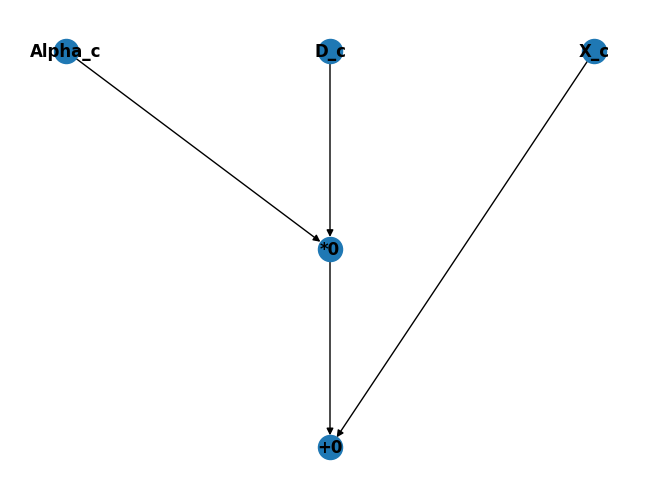

In [10]:
draw_expression_graph(conjugate_gradient_kernel.tensor_expressions[7])